In [1]:
import numpy as np
import pandas as pd
import scipy

import cvxopt.solvers
import logging
import itertools

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Methods implementation

### SVM (Support Vector Machines): own implementation
using materials from: https://d3c33hcgiwev3.cloudfront.net/_a90c16bd5a6f5e0386c4d248f11a4933_5-3.Metricheskie_algoritmy_i_SVM.pdf?Expires=1512950400&Signature=fLjyplrInmTvMJQ3v~3NKWGSrCK-ron2n~ZmObK09LX76NaLKFbTn3PWbUENImZgBzFwZYc7w-0IzFk7GBH115GU60PHhu6XCu4nSyt1SmaCUREkl18dqNk~mE85ag9OqgIJKQk7D3L8PTfoDLurbfI7klgCYBeZJebzgTtrw1A_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A

In [2]:
def kernel(w, x, type='linear', sigma=1, r=0, d=1):
    '''
    Returns K(w,x) - kernel
    '''
    if type == 'linear':
        return np.dot(w,x)
    
    elif type == 'polynomial':
        return (sigma * np.dot(w,x) + r) ** d
    
    elif type == 'radial':
        return exp(- sigma * np.linalg.norm(w - x) ** 2)
    
    elif type == 'gaussian':
        return exp( np.linalg.norm(w - x) ** 2 / (2 * sigma ** 2) )
    
    else:
        print('error: incorrect kernel type')
        return
    return 

def M(y, x, w, w0, kernel_type, sigma, r, d):
    return y * (kernel(w, x, kernel_type) - w0) 

def support_vector_machines_classifier(X, y, w_init=None, C=1,
                   kernel_type='linear', sigma=1, r=0, d=1):
    '''
    Returns optimal weights vector
    
    '''
    if(w_init == None):
        w_init = np.zeros(X.shape[1] + 1)
    
    hinge_loss = lambda w: np.array([max(0,1 - M(y[i], X[i],
                                                 w[1:], w[0], 
                                                 kernel_type, sigma, r, d))
                                     for i in range(len(y))]).sum()
    
    regularization = lambda w: kernel(w[1:], w[1:], kernel_type, sigma, r, d)\
                                / (2 * C)
    
    w = scipy.optimize.minimize(lambda w: hinge_loss(w) + regularization(w),
                                w_init).x
    return w

def support_vector_machines_prediction(w, X, kernel_type='linear', sigma=1, r=0, d=1):
    return np.array([sign(kernel(x, w[1:], kernel_type, sigma, r, d) - w[0]) for x in X])

### SVM (Support Vector Machines) from workshop

In [4]:
class Kernel(object):
    @staticmethod
    def linear():
        return lambda x, y: np.inner(x, y)

    @staticmethod
    def gaussian(sigma):
        return lambda x, y: exp( - np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

MIN_SUPPORT_VECTOR_MULTIPLIER = 1e-5

class SVMTrainer(object):
    def __init__(self, kernel, c=0.1):
        self._kernel = kernel
        self._c = c
    
    def _kernel_matrix(self, X):
        '''
        X: martix of features

        next step: Get number of samples
        next step: Create zero matrix of quadratic shape of number of samples 
        next step: Calculate kernels
        return:    Return Kernels matrix
        '''
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        #print(X)
        for i, x_i in enumerate(X):
            for j, x_j in enumerate(X):
                K[i, j] = self._kernel(x_i, x_j)

        return K

    def _compute_lagrange_multipliers(self, X, y):
        '''
        X: martix of features
        y: vector of labels

        Need to Solve
            min 1/2 x^T P x + q^T x (aplha is x)
            s.t.
                Gx <= h (alpha >= 0)
                Ax = b (y^T * alpha = 0)

        next step: Get number of samples
        next step: Create Kernel matrix by calling _kernel_matrix method
        next step: Create create quadratic term P based on Kernel matrix
        next step: Create linear term q
        next step: Create G, h, A, b
        next step: Solve with - cvxopt.solvers.qp(P, q, G, h, A, b)
        retrun:    Return flatten solution['x']
        '''
        n_samples = X.shape[0]
        K = self._kernel_matrix(X)
        P = cvxopt.matrix(np.outer(y, y) * K)
        q = cvxopt.matrix(-1 * np.ones(n_samples))
        #G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        #h = cvxopt.matrix(np.zeros(n_samples))
        A = cvxopt.matrix(y, (1, n_samples))
        b = cvxopt.matrix(0.0)

        # for regularization
        G_std = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
        h_std = cvxopt.matrix(np.zeros(n_samples))
        G_slack = cvxopt.matrix(np.diag(np.ones(n_samples)))
        h_slack = cvxopt.matrix(np.ones(n_samples) * self._c)
        G = cvxopt.matrix(np.vstack((G_std, G_slack)))
        h = cvxopt.matrix(np.vstack((h_std, h_slack)))
        
        solution = cvxopt.solvers.qp(P, q, G, h, A, b)
        return np.ravel(solution['x'])

    def _create_predictor(self, X, y, lagrange_multipliers):
        '''
        X: martix of features
        y: vector of labels
        lagrange_multipliers: vector of langrange multipliers

        next step: Get non-zero lagrange multipliers indicies
        next step: Get non-zero lagrange multipliers
        next step: Get support vecorts
        next step: Get support vecort labels
        next step: Compute bias (use avg trick)
        retrun   : Return SVMPredictor object
        '''

        support_vector_indices = lagrange_multipliers > MIN_SUPPORT_VECTOR_MULTIPLIER
        support_multipliers = lagrange_multipliers[support_vector_indices]
        support_vectors = X[support_vector_indices]
        support_vector_labels = y[support_vector_indices]

        bias = np.mean(
            [y_k - SVMPredictor(
                    kernel=self._kernel,
                    bias=0.0,
                    weights=support_multipliers,
                    support_vectors=support_vectors,
                    support_vector_labels=support_vector_labels
                ).predict(x_k) for (y_k, x_k) in zip(support_vector_labels, support_vectors)
            ]
        )

        return SVMPredictor(
            kernel=self._kernel,
            bias=0.0,
            weights=support_multipliers,
            support_vectors=support_vectors,
            support_vector_labels=support_vector_labels
        )

    def train(self, X, y):
        '''
        X: martix of features
        y: vector of labels

        next step: Compute lagrange multipliers by calling _compute_lagrange_multipliers method
        return:    Return Predictor object by calling _create_predictor method
        '''
        lagrange_multipliers = self._compute_lagrange_multipliers(X, y)
        return self._create_predictor(X, y, lagrange_multipliers)

class SVMPredictor(object):
    def __init__(self, kernel, bias, weights, 
                 support_vectors, support_vector_labels):
        self._kernel = kernel
        self._bias = bias
        self._weights = weights
        self._support_vectors = support_vectors
        self._support_vector_labels = support_vector_labels

    def predict(self, x):
        '''
        Computes the SVM prediction on the given features x.
        '''
        result = self._bias
        for alpha_i, x_i, y_i in zip(self._weights,
                                 self._support_vectors,
                                 self._support_vector_labels):
            result += alpha_i * y_i * self._kernel(x_i, x)

        return np.sign(result).item()

# Quality check

In [5]:
def accuracy(y, y_pred):
    return np.where(y - y_pred == 0)[0].size / len(y)

#  Visualizing algorithms results

In [6]:
def print_result(true, predict, cut = 5):
    #print('w:\n',coef,'\n')
    if len(true) > cut:
        nl = '\n...\n'
    else:
        nl = '\n'
    print('true vs. prediction:\n',np.vstack((true,predict)).T[:cut],nl)
    print('accuracy: ',round(accuracy(true, predict),3))

In [7]:
def plot_2f_dataset(data, labels, colors=None): 
    from numpy.random import rand
    data = np.array(data)
    labels = np.array(labels)
    n = len(set(labels))
    if(colors == None):
        colors = ListedColormap([tuple(rand(3)) for i in range(n)])
    pyplot.figure(figsize(5, 5))
    pyplot.scatter(data[:,0], data[:,1], c = labels, cmap = colors)
    plt.show()

In [8]:
def plot(predictor, X, y, grid_size):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, grid_size),
        np.linspace(y_min, y_max, grid_size),
        indexing='ij'
    )
    
    flatten = lambda m: np.array(m).reshape(-1,)
    result = []
    for (i, j) in itertools.product(range(grid_size), range(grid_size)):
        point = np.array([xx[i, j], yy[i, j]]).reshape(1, 2)
        result.append(predictor.predict(point))

    Z = np.array(result).reshape(xx.shape)
    
    plt.contourf(
        xx, yy, Z,
        cmap=cm.Paired,
        levels=[-0.01, 0.01],
        extend='both',
        alpha=0.8
    )
    
    plt.scatter(
        flatten(X[:, 0]),
        flatten(X[:, 1]),
        c=flatten(y),
        cmap=cm.Paired
    )
    
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

# Data

### Generate dataset

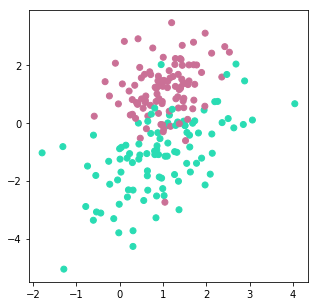

In [9]:
from sklearn import datasets

sample_size = 200
data, target = datasets.make_classification(n_samples=sample_size, n_features=2, 
                                            n_informative=2, n_redundant=0, 
                                            n_repeated=0, n_classes=2, 
                                            n_clusters_per_class=1, 
                                            weights=None, flip_y=0.01, 
                                            class_sep=1.0, hypercube=True, 
                                            shift=0.0, scale=1.0, 
                                            shuffle=True, random_state=True)
target[target == 0] = -1

plot_2f_dataset(data, target)

### Split dataset into train & test samples

In [10]:
from sklearn import cross_validation as cross_val

train_data, test_data, \
train_labels, test_labels = cross_val.train_test_split(data, target,
                                                       test_size = 0.3)

/Users/Yaroslava/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
print('train_data: \n',train_data[:5],'\n...\n')
print('train_labels: \n',train_labels[:5],'...')

train_data: 
 [[ 0.64886118 -2.3259992 ]
 [ 1.0256987  -2.5131986 ]
 [ 1.11238649 -0.69661588]
 [ 0.38965021  0.70128569]
 [-0.78259888 -2.89036611]] 
...

train_labels: 
 [ 1  1  1 -1  1] ...


### Run model and output

### Own

true vs. prediction:
 [[-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [-1. -1.]
 [-1. -1.]
 [-1.  1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]] 
...

accuracy:  0.9


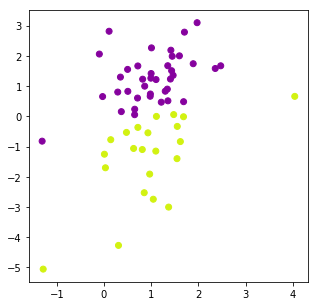

In [61]:
w_init = None
C = 0.1
kernel_type = 'linear' # 'linear', 'polynomial', 'radial', 'gaussian'
sigma = 1
r = 2
d = 1

w = support_vector_machines_classifier(train_data, train_labels, w_init, C, kernel_type, sigma, r, d)
test_labels_predict = support_vector_machines_prediction(w, test_data, kernel_type, sigma, r, d)

print_result(test_labels, test_labels_predict, cut = 10)
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, train_labels_predict)
    plot_2f_dataset(test_data, test_labels_predict)

### From workshop

In [47]:
num_samples = 140
num_features = 2
grid_size = 100
train_data2 = np.matrix(train_data)
train_labels2 = 2 * (train_data2.sum(axis=1) > 0) - 1.0
train_labels2[:] = train_labels.reshape((len(train_labels),1))[:]

     pcost       dcost       gap    pres   dres
 0: -2.4627e+01 -3.2537e+01  1e+03  3e+01  5e-16
 1: -5.9276e+00 -3.0766e+01  4e+01  5e-01  6e-16
 2: -5.7922e+00 -9.9237e+00  4e+00  2e-16  4e-16
 3: -6.4695e+00 -7.1391e+00  7e-01  2e-16  4e-16
 4: -6.6908e+00 -6.8769e+00  2e-01  2e-16  4e-16
 5: -6.7571e+00 -6.8159e+00  6e-02  2e-16  4e-16
 6: -6.7797e+00 -6.7902e+00  1e-02  2e-16  4e-16
 7: -6.7836e+00 -6.7858e+00  2e-03  2e-16  3e-16
 8: -6.7846e+00 -6.7847e+00  1e-04  3e-16  4e-16
 9: -6.7847e+00 -6.7847e+00  4e-06  2e-16  5e-16
Optimal solution found.
true vs. prediction:
 [[-1. -1.]
 [-1. -1.]
 [-1. -1.]
 [ 1.  1.]
 [-1. -1.]
 [-1. -1.]
 [-1.  1.]
 [-1. -1.]
 [-1. -1.]
 [-1. -1.]] 
...

accuracy:  0.9


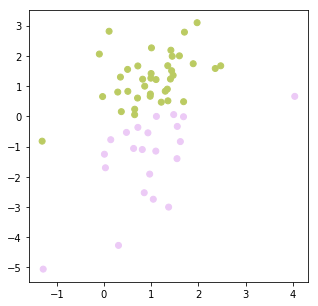

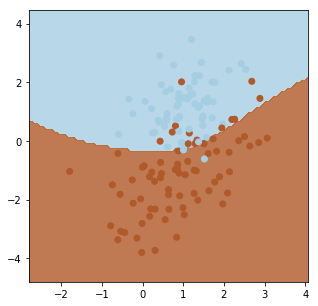

In [43]:
trainer = SVMTrainer(Kernel.gaussian(1))
predictor = trainer.train(train_data2, train_labels2)
np.array([predictor.predict(x) for x in test_data])
print_result(test_labels, test_labels_predict, cut = 10)
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, train_labels_predict)
    plot_2f_dataset(test_data, test_labels_predict)
    plot(predictor, train_data, train_labels, grid_size)

### sklearn.cluster.SVM for check

true vs. prediction:
 [[-1 -1]
 [-1 -1]
 [-1 -1]
 [ 1  1]
 [-1 -1]] 
...

accuracy:  0.883


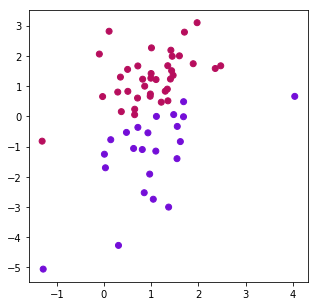

In [54]:
from sklearn import svm

SVM_classifier = svm.LinearSVC()
SVM_classifier.fit(train_data,train_labels)
print_result(test_labels, SVM_classifier.predict(test_data))
if train_data.shape[1] == 2 and (train_data.dtype.type == np.float64
                                 or train_data.dtype.type == np.int64):
    #plot_2f_dataset(train_data, SVM_classifier.predict(train_data))
    plot_2f_dataset(test_data, SVM_classifier.predict(test_data))